# Make way for MOANA (Multi Ordination ANAlysis)
**Author:** Ryan Vandermeulen (NOAA) and Eli Holmes (NOAA)</br>
Last updated: November 18, 2025

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/fish-pace/2025-tutorials/blob/main/vizualization_moana.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Workshop_Hub-green?style=for-the-badge)][jupyter-link]

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/vizualization_moana.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/vizualization_moana.ipynb
[jupyter-link]: https://workshop.nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/vizualization_moana.ipynb

>📘 Learning Objectives
>
> 1. Create pretty maps of the three phytoplankton classes in MOANA
> 2. Plot how all three of these phytoplankton classes change in relation to latitude
> 3. Plot how all three of these phytoplankton classes change over the course of 1 year
> 4. Create a ternary plot and map that shows where each phytoplankton class dominates


## You will need a full 2Gb for this tutorial

Go to Kernel > ShutDown All Kernels to free up all your memory if you are in a 2Gb instance.

## Interacting with multiple phytoplankton groups simultaneously

MOANA is the first phytoplankton community composition algorithm to be released by PACE. This product returns near-surface concentrations (cells mL-1) of three different picophytoplankton (i.e., phytoplankton <2 μm in size): Prochlorococcus, Synechococcus, and autotrophic picoeukaryotes (Figure 15). The algorithm uses empirical relationships between measured cell concentrations, in situ hyperspectral remote sensing reflectances, and sea surface temperatures. Details of this algorithm can be found in [Lange et al. (2020)](https://doi.org/10.1364/OE.398127).

Picophytoplankton are composed of the cyanobacteria Prochlorococcus (∼0.8 µm) and Synechococcus (∼1 µm), as well as picoeukaryotes, which combined are responsible for 50 to 90% of all primary production in open ocean ecosystems and contribute up to 30% of carbon export in these regions. Geographically, Prochlorococcus tends to inhabit warmer and mostly oligotrophic waters surrounded by Synechococcus patches along frontal boundaries. These fronts often reside at boundaries where phytoplankton communities start to transition to higher concentrations of larger eukaryotic cells, such as picoeukaryotes and nanoeukaryotic flagellates. Thus, identification of Prochlorococcus and Synechococcus distributions may be useful in identifying trophic boundaries in oceanic ecosystems, in addition to providing insight into productivity, food web regimes, and carbon export.

Note, for now, the MOANA product is only available for the Atlantic Ocean.

## Load the data from NASA Earthdata

We are getting the 8-day MOANA data at the 4km resolution.

In [1]:
# If you are on Colab uncomment this and run first to install packages
#!pip install earthaccess cartopy

In [2]:
import earthaccess
import xarray as xr
auth = earthaccess.login(persist=True)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L4M_MOANA',
    temporal = ("2024-09-01", "2024-09-02"),
    granule_name="*.8D.*.4km.*"
)
len(results)

1

In [3]:
# Check the file name
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240828_20240904.L4m.8D.MOANA.V3_1.4km.nc']]

In [4]:
# Load the data
fileset = earthaccess.open(results)
ds = xr.open_dataset(fileset[0])
ds

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 213MB
Dimensions:          (lat: 3360, lon: 2640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 13kB 69.98 69.94 69.9 ... -69.9 -69.94 -69.98
  * lon              (lon) float32 11kB -84.98 -84.94 -84.9 ... 24.9 24.94 24.98
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (lat, lon) float64 71MB ...
    syncoccus_moana  (lat, lon) float64 71MB ...
    picoeuk_moana    (lat, lon) float64 71MB ...
    palette          (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/62)
    product_name:                      PACE_OCI.20240828_20240904.L4m.8D.MOAN...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L4M/MOANA/3.1
    data_bins:                         3256679
    data_minimum:                      0.0
    data_maximum:                      2850208300.0

In [5]:
# ---- Load Libraries for printing ----
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gc

# ---- Create a coarsen function to speed up plotting
# subsample the lat/lons. We don't need to show all
def coarsen_da(da, step=2):
    return da.isel(lat=slice(None, None, step),
                   lon=slice(None, None, step))

## Map time!

We have three different phytoplankton classes in this MOANA data set. Let's create some pretty maps and get a sense of their relative distributions.

In [6]:
# ---- Define metadata for plots ----
phyto_info = {
    "Prochlorococcus": {
        "data": ds["prococcus_moana"],
        "cmap": plt.cm.Blues,
        "label": "Prochlorococcus conc. (cells mL⁻¹)"
    },
    "Synechococcus": {
        "data": ds["syncoccus_moana"],
        "cmap": plt.cm.Reds,
        "label": "Synechococcus conc. (cells mL⁻¹)"
    },
    "Picoeukaryotes": {
        "data": ds["picoeuk_moana"],
        "cmap": plt.cm.Greens,
        "label": "Picoeukaryote conc. (cells mL⁻¹)"
    }
}

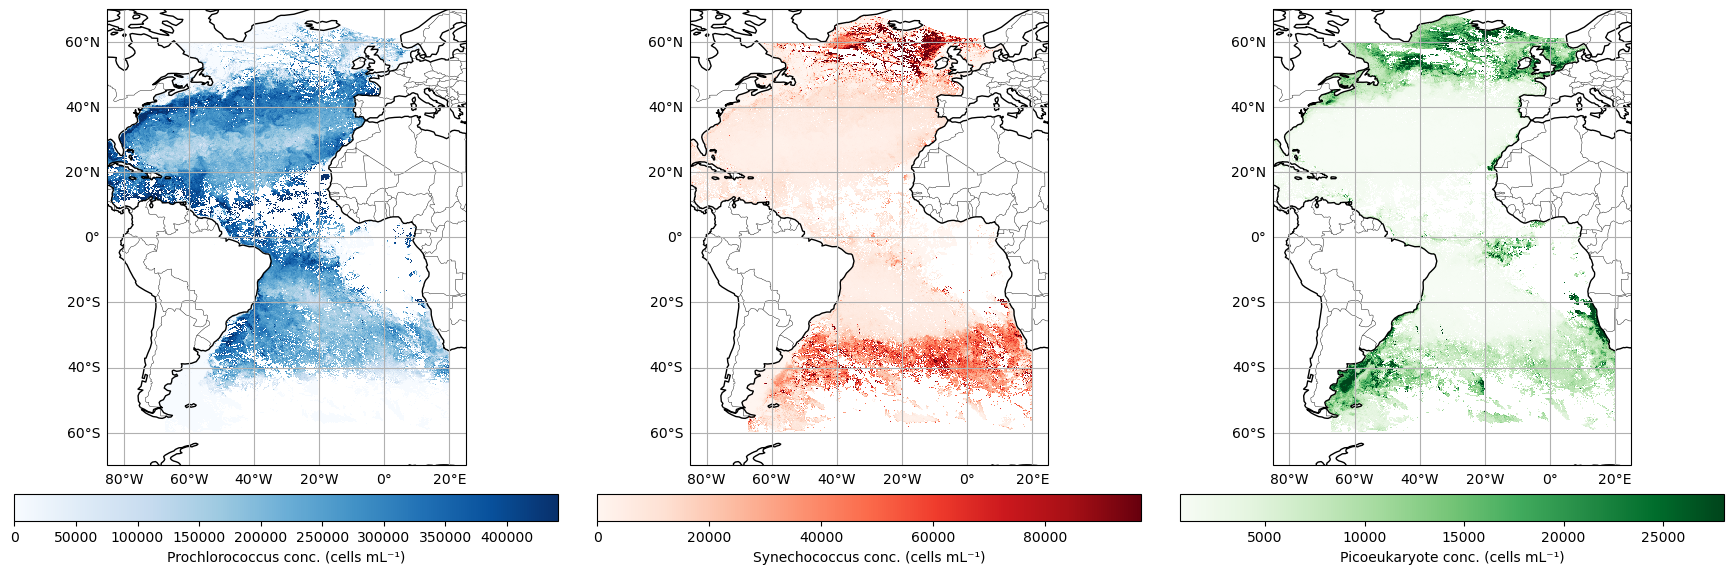

In [7]:
# ---- Set up figure and axes ----
fig, axs = plt.subplots(1, 3, figsize=(18, 6),
                        subplot_kw={'projection': ccrs.PlateCarree()})

# ---- Plot each phytoplankton group ----
for ax, (title, info) in zip(axs, phyto_info.items()):
    da = coarsen_da(info["data"], step=4) 
    ax.set_title(title)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False

    img = da.plot(
        ax=ax,
        cmap=info["cmap"],
        robust=True,
        add_colorbar=False
    )

    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
    cbar.set_label(info["label"])

plt.tight_layout()
plt.show()

In [8]:
# Do some clean up of memory
plt.close('all')
gc.collect()

0

Looking good! Here you can see that Prochlorococcus really runs amok in the offshore waters, while Synechococcus and Picoeukaryotes tend to dominate at higher latitudes, and Picoeukaryotes assert their dominance in along the coastal margins...to the degree that a free-floating cell can "assert" anything.

## Let's get a bit more quantitative

Let's get a little better sense of how these phytoplankton classes are geographically distributed. We will plot how all three of these phytoplankton classes change in relation to latitude. To do this, we will take "slices" of data and plot the median. Conceptually, think of a horizontal line across 50 degrees North - we'll extract all that data, take the median, and then move on to the pixel below (e.g. 49.98 degrees North) and do the same until we hit 50 degrees South. Doing this for each phytoplankton class, we can now distill this information into something that can be put onto a line plot. 

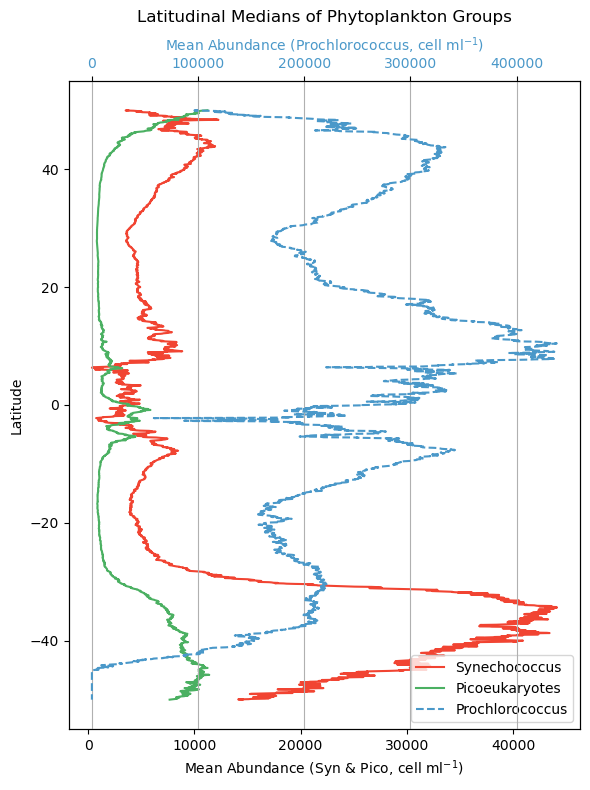

In [9]:
# median since the latitudinal data have outliers
syn = ds["syncoccus_moana"].sel(lat = slice(50, -50)).median(dim=["lon"])
pro = ds["prococcus_moana"].sel(lat = slice(50, -50)).median(dim=["lon"])
pico = ds["picoeuk_moana"].sel(lat = slice(50, -50)).median(dim=["lon"])

custom_colors = {
    "Prochlorococcus": plt.cm.Blues(0.6),
    "Synechococcus": plt.cm.Reds(0.6),
    "Picoeukaryotes": plt.cm.Greens(0.6)
}

fig, ax1 = plt.subplots(figsize=(6, 8))  # Taller figure for vertical layout

# Primary axis: Syn and Pico
ax1.plot(syn, syn["lat"], label="Synechococcus", color=custom_colors["Synechococcus"])
ax1.plot(pico, pico["lat"], label="Picoeukaryotes", color=custom_colors["Picoeukaryotes"])
ax1.set_ylabel("Latitude")
ax1.set_xlabel("Mean Abundance (Syn & Pico, cell ml$^{-1}$)", color="black")
ax1.tick_params(axis='x', labelcolor="black")

# Secondary axis: Prochlorococcus
ax2 = ax1.twiny()
ax2.plot(pro, pro["lat"], label="Prochlorococcus", color=custom_colors["Prochlorococcus"], linestyle="--")
ax2.set_xlabel("Mean Abundance (Prochlorococcus, cell ml$^{-1}$)", color=custom_colors["Prochlorococcus"])
ax2.tick_params(axis='x', labelcolor=custom_colors["Prochlorococcus"])

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="lower right")

plt.title("Latitudinal Medians of Phytoplankton Groups", pad=10)
plt.grid(True)
plt.tight_layout()
plt.show()

Note that Prochlorococcus is on a separate axis here because the cells are so abundant. That doesn't necessarily mean they represent a larger amount of biomass across the board though. *Prochlorococcus* are teeny tiny little cyanobacteria cells, and *Synechococcus* and picoeukaryotes are larger, so in the latter case, fewer cells can represent more overall biomass. We make this distinction here becuase when we later consider which phytoplankton class is "dominant" in an area, it is relative to their respective range of concentrations, not absolute cell counts.

## The times, they are a changin'

For this exercise, we'll download one year's worth of PACE data to see how things are evolving over time. Using this time series, we will use the "slice" function again, but this time we'll extract a 10 degree x 10 degree box in the southern Atlantic Ocean. It can be smaller, or located elsewhere if you like, but either way, we're going to average the data within that box for each individual time step.

Next, we'll plot how all three of these phytoplankton classes change over the course of 1 year, allowing you to see the cycles of growth and decay relative to one another. It is useful to add this context because not all chlorophyll-a is equivalent, e.g., a bloom of *Prochlorococcus* may represent a different amount of trophic energy potential relative to blooms of other phytoplankton classes, or it may have come about from a different oceanographic process. 

**Loading lots of files with `open_mfdataset()`**

We are doing this in this example as a convenience, but be aware that this uses more memory than needed. We could loop over files and compute the median values and that would only load one file worth of data into memory at a time. If we wanted to work with a decade of data, we would need a strategy like that in order to manage memory usage.

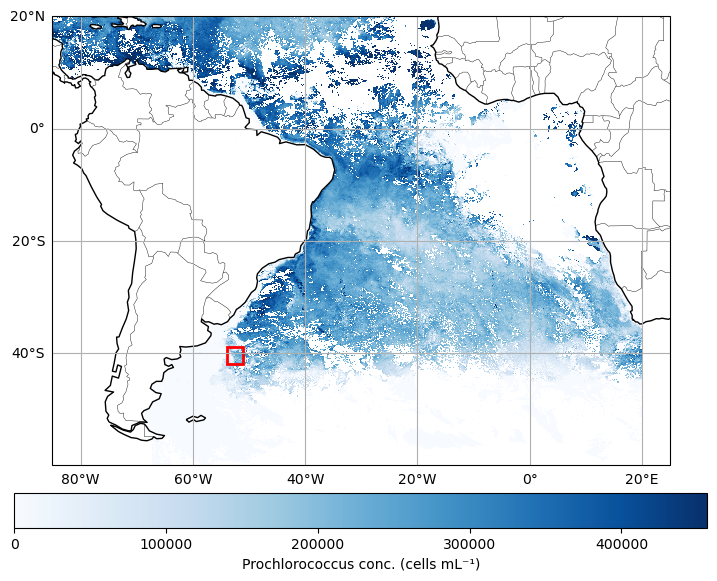

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# Bounding box
lon_min, lon_max = -54, -51
lat_min, lat_max = -42, -39

# Choose one phytoplankton group
title = "Prochlorococcus"
data = ds["prococcus_moana"].sel(lat=slice(20, -60))
data = coarsen_da(data, step=4)
cmap = plt.cm.Blues
label = "Prochlorococcus conc. (cells mL⁻¹)"

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Base map
ax.set_title(title)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False

# Plot the data
img = data.plot(ax=ax, cmap=cmap, robust=True, add_colorbar=False, vmin=0)

# Add bounding box
ax.add_patch(Rectangle((lon_min, lat_min),
                       lon_max - lon_min,
                       lat_max - lat_min,
                       edgecolor='red',
                       facecolor='none',
                       linewidth=2,
                       transform=ccrs.PlateCarree()))

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
cbar.set_label(label)

plt.tight_layout()
plt.show()


Load data and select our box.

In [11]:
import earthaccess
import xarray as xr
auth = earthaccess.login(persist=True)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L4M_MOANA',
    temporal = ("2024-03-01", "2025-03-02"),
    granule_name="*.8D.*.4km.*"
)
len(results)

46

In [12]:
# the netcdfs do not have time so we need to get that from the results metadata
# Use the beginning of each 8-day window as the time coordinate
import numpy as np
time = [
    np.datetime64(r["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"][:10])
    for r in results
]

In [13]:
# Creating a big dataset like this takes a bit of memory
fileset = earthaccess.open(results)
dataset = xr.open_mfdataset(fileset, concat_dim="time", combine="nested")
dataset = dataset.assign_coords(time=("time", time))
dataset

QUEUEING TASKS | :   0%|          | 0/46 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/46 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/46 [00:00<?, ?it/s]

<xarray.Dataset> Size: 10GB
Dimensions:          (time: 46, lat: 3360, lon: 2640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 13kB 69.98 69.94 69.9 ... -69.9 -69.94 -69.98
  * lon              (lon) float32 11kB -84.98 -84.94 -84.9 ... 24.9 24.94 24.98
  * time             (time) datetime64[s] 368B 2024-03-05 ... 2025-02-26
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (time, lat, lon) float64 3GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (time, lat, lon) float64 3GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (time, lat, lon) float64 3GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (time, rgb, eightbitcolor) uint8 35kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240305_20240312.L4m.8D.MOAN...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L4M/MOANA/3.1
    data_bins:                         3191916
    data_minimum:                      0.0
    data_maximum:                      2116797900000.0

In [14]:
# --- Subset to our region of interest ----
da=dataset.sel(lat=slice(-39,-42), lon=slice(-54,-51))

# Get the mean over the box
syn_ts = da["syncoccus_moana"].median(dim=["lat", "lon"])
pico_ts = da["picoeuk_moana"].median(dim=["lat", "lon"])
pro_ts = da["prococcus_moana"].median(dim=["lat", "lon"])

pro_ts

<xarray.DataArray 'prococcus_moana' (time: 46)> Size: 368B
dask.array<nanmedian, shape=(46,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[s] 368B 2024-03-05 2024-03-13 ... 2025-02-26

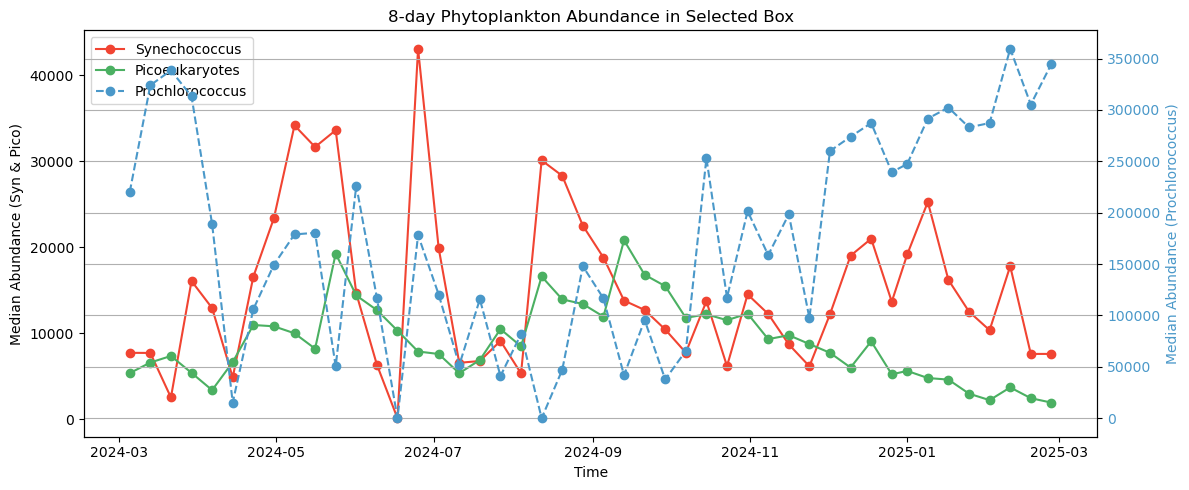

In [15]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 5))

custom_colors = {
    "Prochlorococcus": plt.cm.Blues(0.6),
    "Synechococcus": plt.cm.Reds(0.6),
    "Picoeukaryotes": plt.cm.Greens(0.6)
}

# Plot syn and pico on the left y-axis
ax1.plot(syn_ts["time"], syn_ts, 'o-', label="Synechococcus", color=custom_colors["Synechococcus"])
ax1.plot(pico_ts["time"], pico_ts, 'o-', label="Picoeukaryotes", color=custom_colors["Picoeukaryotes"])
ax1.set_xlabel("Time")
ax1.set_ylabel("Median Abundance (Syn & Pico)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Create a secondary y-axis for prococcus_moana
ax2 = ax1.twinx()
ax2.plot(pro_ts["time"], pro_ts, 'o--', label="Prochlorococcus", color=custom_colors["Prochlorococcus"])
ax2.set_ylabel("Median Abundance (Prochlorococcus)", color=custom_colors["Prochlorococcus"])
ax2.tick_params(axis='y', labelcolor=custom_colors["Prochlorococcus"])

# Combine all legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Add title and grid
plt.title("8-day Phytoplankton Abundance in Selected Box")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Do some clean up of memory
plt.close('all')
gc.collect()

6152

## Bringing it all together

A central theme of working with PACE data revolves around wrangling multiple dimensions of data into something you can conceptualize. Viewing three separate maps makes it a bit difficult to see the interactions between the different phytoplankton classes. This is important - we want to know where these boundaries are colliding, because this indicates that something is changing with the underlying oceanography. 

Let's try something a little different here. Instead of making three separate plots, let's stack them all and make a false "true color" image by substituting the usual red, green, and blue radiance channels with *Synechococcus* (red), Picoeukaryotes (green), and *Proclorococcus* (blue). Can it be done? 

Yes, but with a tiny bit of nuance here. We talked earlier about how higher cell counts does not unequivocally mean that this is a "dominant" class. We can do something called histogram stretching, which is a little trick some folks use to make their true color images pop a little more. Basically, for each phytoplankton class, let's take all the data between the 2% and 98% percentile range, and normalize those data to the respective median. This ensures all phytoplankton classes are now on a level playing field when we stack them up. Higher or lower values no longer represent absolute cell counts, they now represent higher or lower weights relative to their central tendency. The same trick is often done for making "true color" images to make them pop a little more. Let's give it a try.

First subset our Sept 1, 2024 image to a smaller region.

In [17]:
# ---- Subset to North Atlantic off US Coast ----
extent = [-84, -20, 15, 60]
ds = ds.sel(lat=slice(60,15), lon=slice(-84,-20))

Create a "red, green, blue" stack

In [18]:
import numpy as np

# ---- Normalize using robust percentile-based scaling ----
def robust_normalize(arr):
    vmin, vmax = np.nanpercentile(arr, [2, 98])
    return np.clip((arr - vmin) / (vmax - vmin), 0, 1)

# ---- Define our colors ----
# use coarsen_da to subsample the lat/lon for faster plotting
phyto_rgb = {
    "R": coarsen_da(ds["syncoccus_moana"], step=2),
    "G": coarsen_da(ds["picoeuk_moana"], step=2),
    "B": coarsen_da(ds["prococcus_moana"], step=2)
}

# ---- Create a stack for implot ----
rgb_image = np.stack([robust_normalize(da.values) for da in phyto_rgb.values()], axis=-1)
rgb_image[np.isnan(rgb_image)] = 0
rgb_image = np.flipud(rgb_image)

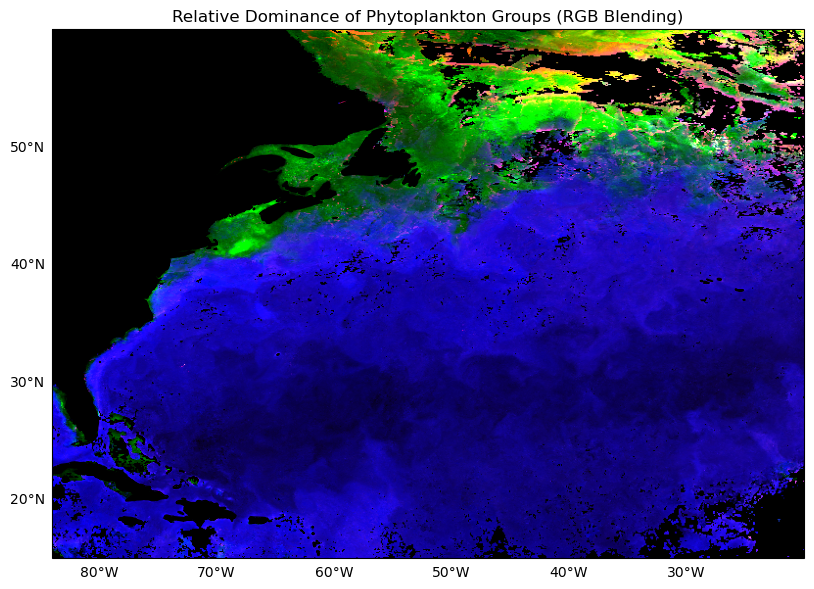

In [19]:
# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title("Relative Dominance of Phytoplankton Groups (RGB Blending)")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Grid labels only
gl = ax.gridlines(draw_labels=True, linewidth=0, color='none')
gl.right_labels = gl.top_labels = False

# extent defined when data set up above
ax.imshow(rgb_image, origin='lower', extent=extent, transform=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

Now you can really see where each phytoplankton class dominates, and through the gradational mixing of colors, we can see where, and to what degree they overlap. 

## Create a legend

We still could use a bit of help contextualizing the above image, so let's just make a little legend for it. Since we're in tricolor space, let's create a legend that shows the relative contribution of three variables relative to one another. It helps us determine how to interpret the purple, teal, pink, and orange areas you see on the map.  

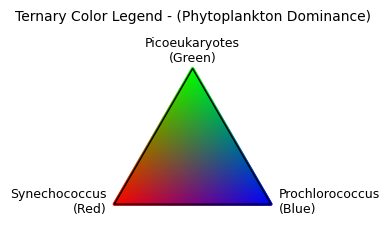

In [20]:
from matplotlib.patches import Polygon

# Define triangle vertices (RGB space: R=Syn, G=Pico, B=Pro)
triangle = np.array([
    [0.5, np.sqrt(3)/2],  # top = Pico (Green)
    [0, 0],               # bottom left = Syn (Red)
    [1, 0]                # bottom right = Pro (Blue)
])

# Create barycentric coordinates for triangle
res = 150
bary_coords = np.array([
    [i / res, j / res, 1 - i / res - j / res]
    for i in range(res + 1)
    for j in range(res + 1 - i)
])
rgb_vals = bary_coords[:, [1, 0, 2]]  # R=Syn, G=Pico, B=Pro
rgb_vals = np.clip(rgb_vals, 0, 1)

# Convert to triangle (x, y) coordinates
xy_coords = (bary_coords[:, 0:1] * triangle[0] +
             bary_coords[:, 1:2] * triangle[1] +
             bary_coords[:, 2:3] * triangle[2])

# Plot the ternary color key
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect('equal')
ax.axis('off')

ax.scatter(xy_coords[:, 0], xy_coords[:, 1], c=rgb_vals, s=2)
ax.add_patch(Polygon(triangle, closed=True, edgecolor='black', fill=False))

# Labels
ax.text(0.5, np.sqrt(3)/2 + 0.05, "Picoeukaryotes\n(Green)", ha='center', fontsize=9)
ax.text(-0.05, -0.05, "Synechococcus\n(Red)", ha='right', fontsize=9)
ax.text(1.05, -0.05, "Prochlorococcus\n(Blue)", ha='left', fontsize=9)

plt.title("Ternary Color Legend - (Phytoplankton Dominance)", fontsize=10, pad=30)
plt.tight_layout()
plt.show()

## Summary

There you have it! MOANA is PACE's first phytoplankton class algorithm. Note, even if these specific critters are not of particular interest to you, they are excellent indicators of underlying oceanographic processes (MOANA uses SST as an input as well). If you are a highly migratory species traversing the open seas, these boundaries may very well be influential. 